<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/manim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt update
!sudo apt install libcairo2-dev ffmpeg \
    texlive texlive-latex-extra texlive-fonts-extra \
    texlive-latex-recommended texlive-science \
    tipa libpango1.0-dev
!pip install manim
!pip install IPython==8.21.0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,030 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 http://archive

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.0/810.0 kB 39.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: IPython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.21.0 which is incompatible.


In [1]:
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git && cd cursivetransformer && pip install -r requirements.txt
import sys
sys.path.append('/content/cursivetransformer')

Cloning into 'cursivetransformer'...
remote: Enumerating objects: 2262, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 2262 (delta 359), reused 352 (delta 326), pack-reused 1865 (from 1)
Receiving objects: 100% (2262/2262), 29.97 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (1273/1273), done.
  Using cached wandb-0.18.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
Using cached wandb-0.18.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)


In [2]:
import torch
from manim import *
import numpy as np
from cursivetransformer.model import get_all_args, get_checkpoint
from cursivetransformer.data import create_datasets, load_and_parse_data, generate_word_combos, offsets_to_strokes
from cursivetransformer.sample import plot_strokes, save_samples, generate_n_words, generate

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'
args.dataset_name = 'bigbank'
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
train_dataset, test_dataset = create_datasets(args)
args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()
print(f"Dataset determined that: {args.vocab_size=}, {args.block_size=}")
model, _, _, _, _ = get_checkpoint(args)

model_device = next(model.parameters()).device
warmup_steps = 100
do_sample = False
num = 1
stroke_seq, context = [], []
for i in range(num):
  x, c, y = test_dataset[i]
  stroke_seq.append(x) ; context.append(c)

X_init = torch.stack(stroke_seq).to(model_device)[:,:warmup_steps]
context = torch.stack(context).long().to(model_device)
top_k = None
steps = test_dataset.get_stroke_seq_length() - 1  # -1 because we already start with the first token

X_samp = generate(model, X_init, context, steps, top_k=top_k, do_sample=do_sample).to('cpu')

examples = []
for i in range(X_samp.size(0)):
    # get the i'th row of sampled integers, as python list
    stroke_tokens = stroke_seq[i].detach().cpu().numpy()
    offset_stroke = test_dataset.decode_stroke(stroke_tokens)
    stroke_points = offsets_to_strokes(offset_stroke)
    row = X_samp[i].detach().cpu().numpy()
    offset_samp = test_dataset.decode_stroke(row)
    sample_points = offsets_to_strokes(offset_samp)
    ascii_sequence = test_dataset.decode_text(context[i])
    examples.append(dict(stroke_points=stroke_points, sample_points=sample_points, ascii_sequence=ascii_sequence))

For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples
Dataset determined that: args.vocab_size=455, args.block_size=1000
Number of Transformer parameters: 368064
Model #params: 397184
Loaded model from local path: best_checkpoint.pt


## Animations

### Plotting Strokes

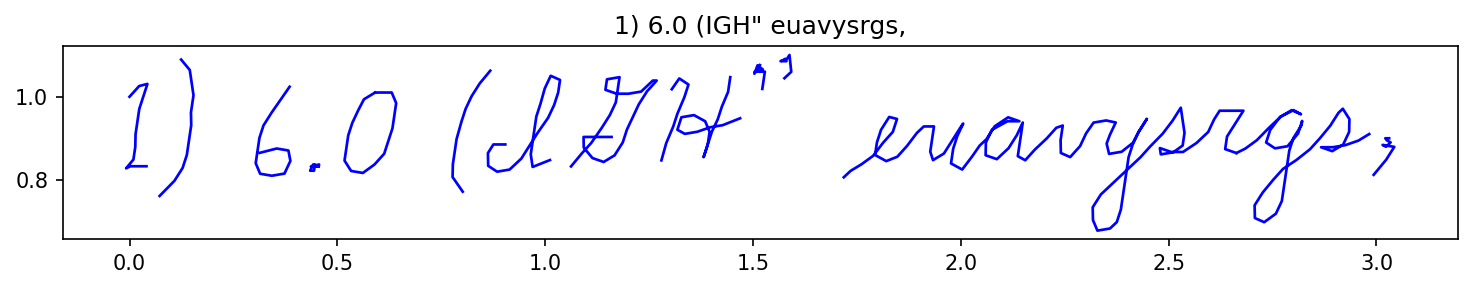

In [8]:
points = examples[0]['stroke_points']
ascii_sequence = examples[0]['ascii_sequence']
_ = plot_strokes(points, title=ascii_sequence)

In [9]:
%%manim -qm -v WARNING PlotStrokesAnimation

class PlotStrokesAnimation(Scene):
    def construct(self):
        # Title
        title = Text("Plotting Handwritten Example", font_size=36)
        title.to_edge(UP)
        self.play(Write(title))
        self.wait(1)



        # Convert stroke data into Manim mobjects
        strokes = self.create_strokes(points)

        # # Display the strokes
        # self.play(Create(strokes, run_time=5))
        # self.wait(2)

        # Add label for the ASCII sequence
        label = Text(f"ASCII Sequence: {ascii_sequence}", font_size=24)
        label.next_to(strokes, DOWN)
        self.play(Write(label))
        self.wait(3)

        # - [ ] TODO,DEBUG: Display the strokes AFTER the ascii sequence
        self.play(Create(strokes, run_time=5))
        self.wait(2)

    def create_strokes(self, points):
        # Initialize variables
        stroke_paths = VGroup()
        path_points = []  # List to hold points for the current path

        # Iterate through the points
        for i in range(len(points)):
            x, y, p = points[i]
            # Invert the y-coordinate
            y = -y
            point = np.array([x, y, 0])

            if p == 1:
                # Pen down, collect points
                path_points.append(point)
            else:
                # Pen up, create a path if there are collected points
                if path_points:
                    current_path = VMobject()
                    current_path.set_points_as_corners(path_points)
                    stroke_paths.add(current_path)
                    path_points = []  # Reset for the next path

        # Add the last path if any points remain
        if path_points:
            current_path = VMobject()
            current_path.set_points_as_corners(path_points)
            stroke_paths.add(current_path)

        # Style the strokes
        stroke_paths.set_stroke(color=BLUE, width=2)
        stroke_paths.move_to(ORIGIN)

        # Scale strokes to fit the scene
        stroke_paths.scale(3)

        return stroke_paths

Manim Community v0.18.1

### Plotting Model Outputs

In [11]:
%%manim -qm -v WARNING PlotModelOutputAnimation

class PlotModelOutputAnimation(PlotStrokesAnimation):
    def construct(self):
        # Title
        title = Text("Plotting Model Handwritten Example", font_size=36)
        title.to_edge(UP)
        self.play(Write(title))
        self.wait(1)

        for example in examples:
            stroke_points = example['stroke_points']
            sample_points = example['sample_points']
            ascii_sequence = example['ascii_sequence']
            # Convert sampled data into Manim mobjects
            strokes = self.create_strokes(sample_points)

            # Display the strokes
            # self.play(Create(strokes, run_time=5))
            # self.wait(2)

            # Add label for the ASCII sequence
            label = Text(f"ASCII Sequence: {ascii_sequence}", font_size=24)
            label.next_to(strokes, DOWN)
            self.play(Write(label))
            self.wait(3)

            # - [ ] TODO,DEBUG: Display the strokes AFTER the ascii sequence
            self.play(Create(strokes, run_time=5))
            self.wait(2)

Manim Community v0.18.1

## Animation Graveyard

### Stroke Tokenization

In [ ]:
%%manim -qm -v WARNING StrokeTokenizationAnimation

class StrokeTokenizationAnimation(Scene):
    def construct(self):
        # Title
        title = Text("Cursive Transformer Tokenization Scheme", font_size=36)
        title.to_edge(UP)
        self.play(Write(title))
        self.wait(1)

        # Step 1: Raw Stroke Data Visualization
        self.raw_stroke_data()

        # Step 2: Compute Offsets
        self.compute_offsets()

        # Step 3: Convert to Polar Coordinates
        self.convert_to_polar()

        # Step 4: Binning and Token Assignment
        self.binning_and_token_assignment()

        # Step 5: Final Token Sequence
        self.final_token_sequence()

    def raw_stroke_data(self):
        # Raw stroke data points (x, y, pen_state)
        self.raw_points = [
            [-5, 2, 0], [-4, 2.5, 0], [-3, 2, 0], [-2, 1.5, 0],
            [-1, 1, 0], [0, 0.5, 0], [1, 0, 0], [2, -0.5, 0]
        ]
        self.pen_states = [1]*len(self.raw_points)  # Pen down for all points

        # Create dots for each point (use full 3D points)
        dots = VGroup(*[
            Dot(point=point, color=BLUE)
            for point in self.raw_points
        ])

        # Create lines between points
        lines = VGroup(*[
            Line(self.raw_points[i], self.raw_points[i+1], color=BLUE)
            for i in range(len(self.raw_points)-1)
        ])

        # Group dots and lines
        stroke = VGroup(lines, dots).shift(LEFT*3)
        stroke_label = Text("Raw Stroke Data (x, y, p)", font_size=24)
        stroke_label.next_to(stroke, DOWN)

        self.play(Create(stroke), Write(stroke_label))
        self.wait(2)

        # Store for later use
        self.stroke = stroke
        self.stroke_label = stroke_label

    def compute_offsets(self):
        # Transition
        self.play(
            self.stroke.animate.shift(UP*2 + LEFT*2),
            self.stroke_label.animate.shift(UP*2 + LEFT*2),
        )

        # Compute offsets (Δx, Δy, p)
        self.offsets = []
        for i in range(1, len(self.raw_points)):
            dx = self.raw_points[i][0] - self.raw_points[i-1][0]
            dy = self.raw_points[i][1] - self.raw_points[i-1][1]
            p = self.pen_states[i]
            self.offsets.append([dx, dy, p])

        # Display offsets as arrows
        offset_arrows = VGroup(*[
            Arrow(
                start=self.raw_points[i-1],
                end=self.raw_points[i],
                buff=0,
                color=GREEN
            )
            for i in range(1, len(self.raw_points))
        ])

        offsets_label = Text("Offsets (Δx, Δy, p)", font_size=24)
        offsets_label.next_to(offset_arrows, DOWN)

        self.play(Create(offset_arrows), Write(offsets_label))
        self.wait(2)

        # Store for later use
        self.offset_arrows = offset_arrows
        self.offsets_label = offsets_label

    def convert_to_polar(self):
        # Transition
        self.play(
            self.offset_arrows.animate.shift(RIGHT*4),
            self.offsets_label.animate.shift(RIGHT*4),
        )

        # Convert to polar coordinates (r, θ, p)
        self.polar_coords = []
        for offset in self.offsets:
            dx, dy, p = offset
            r = np.hypot(dx, dy)
            theta = np.arctan2(dy, dx)
            self.polar_coords.append([r, theta, p])

        # Display polar vectors
        origin_points = [self.raw_points[i-1] for i in range(1, len(self.raw_points))]
        polar_arrows = VGroup(*[
            Arrow(
                start=origin,
                end=origin + np.array([
                    coord[0]*np.cos(coord[1]),
                    coord[0]*np.sin(coord[1]),
                    0
                ]),
                buff=0,
                color=YELLOW
            )
            for origin, coord in zip(origin_points, self.polar_coords)
        ])

        polar_label = Text("Polar Coordinates (r, θ, p)", font_size=24)
        polar_label.next_to(polar_arrows, DOWN)

        self.play(Create(polar_arrows), Write(polar_label))
        self.wait(2)

        # Store for later use
        self.polar_arrows = polar_arrows
        self.polar_label = polar_label

    def binning_and_token_assignment(self):
        # Transition
        self.play(
            self.offsets_label.animate.shift(UP*3 + LEFT*4),
            self.polar_label.animate.shift(UP*3 + RIGHT*2),
        )
        self.play(
            FadeOut(self.stroke),
            FadeOut(self.stroke_label),
            FadeOut(self.offset_arrows),
            FadeOut(self.polar_arrows),
        )

        # Bins as per StrokeDataset
        theta_bins = np.linspace(-np.pi, np.pi, 151)
        r_bins_pen_down = np.concatenate([
            np.array([0]),
            np.linspace(0.0001, 0.050, 50),
            np.geomspace(0.051, 2.25, 101)[:-1]
        ])
        r_bins_pen_up = r_bins_pen_down + max(r_bins_pen_down) + 1
        r_bins = np.concatenate([r_bins_pen_down, r_bins_pen_up])

        # Cumulative sizes
        feature_sizes = [len(r_bins), len(theta_bins)]
        cumulative_sizes = np.cumsum([0] + feature_sizes)

        # Token IDs and assignments
        token_assignments = []
        for coord in self.polar_coords:
            r, theta, p = coord
            # Binning theta
            theta_idx = np.digitize(theta, theta_bins) - 1
            theta_token = theta_idx + cumulative_sizes[1]

            # Binning r
            if p == 1:  # Pen down
                r_idx = np.digitize(r, r_bins_pen_down) - 1
            else:  # Pen up
                r_idx = np.digitize(r, r_bins_pen_up) - 1 + len(r_bins_pen_down)
            r_token = r_idx + cumulative_sizes[0]

            token_assignments.append((theta_token, r_token))

        # Store for later use
        self.token_assignments = token_assignments

        # Display token assignments
        tokens_text = VGroup()
        for i, (theta_token, r_token) in enumerate(self.token_assignments):
            text = Text(
                f"Token {2*i+1}: θ ID {theta_token}\n"
                f"Token {2*i+2}: r ID {r_token}",
                font_size=20, line_spacing=1
            ).shift(LEFT*3 + DOWN*(i - len(self.token_assignments)/2))
            tokens_text.add(text)

        tokens_label = Text("Binning and Token Assignment", font_size=24)
        tokens_label.next_to(tokens_text, UP)

        self.play(Write(tokens_label), Write(tokens_text))
        self.wait(3)

        # Store for later use
        self.tokens_text = tokens_text

    def final_token_sequence(self):
        # Transition
        self.play(
            FadeOut(self.offsets_label),
            FadeOut(self.polar_label),
            FadeOut(self.tokens_text),
        )

        # Create final token sequence
        final_tokens = []
        for theta_token, r_token in self.token_assignments:
            final_tokens.append(theta_token)
            final_tokens.append(r_token)

        tokens_str = ", ".join(map(str, final_tokens))
        final_text = Text(
            f"Final Token Sequence:\n[{tokens_str}]",
            font_size=24, line_spacing=1.5
        )

        self.play(Write(final_text))
        self.wait(3)

        # Conclusion
        conclusion = Text(
            "This token sequence is input to the Transformer model.",
            font_size=24
        ).next_to(final_text, DOWN, buff=1)
        self.play(Write(conclusion))
        self.wait(3)